In [1]:
! gpustat

ta                   Tue Oct 19 19:33:41 2021  440.95.01
[0] TITAN RTX        | 24'C,   0 % |   951 / 24220 MB | wzx(939M)
[1] TITAN RTX        | 74'C,  96 % |  9165 / 24219 MB | wzx(7629M) gdm(21M) gdm(60M)


In [2]:
import seq2seq
import matplotlib.pyplot as plt
%matplotlib inline

/home/aiman/anaconda3/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Load dependencies

In [3]:
import tqdm
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
%matplotlib inline

from IPython.core.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Dataset, Example, Field
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score
from torchtext.datasets import Multi30k

import time
import re
import os

In [4]:
from torchtext import vocab , data
from torchtext.data import TabularDataset, Field, Iterator, BucketIterator, ReversibleField
from torchtext.vocab import Vectors, FastText

import pyarabic.araby as araby
import pyarabic.number as number

In [5]:
import bpemb
from bpemb import BPEmb
bpemb_ar = BPEmb(lang="en", vs=1000, dim=300) 

In [6]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [7]:
SEED = 5002
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda:0') #torch.device('cuda:0')
print(f'Device: {DEVICE}')

Device: cuda:0


## Prepare data

In [8]:
def normalizeString(s):
    s = bpemb_ar.encode(s)
    return s

In [9]:
SRC = Field(tokenize= normalizeString, init_token='<sos>', eos_token='<eos>', batch_first=True) 
TRG = Field(tokenize= normalizeString, init_token='<sos>', eos_token='<eos>', batch_first=True) 

In [10]:
train_data, valid_data, test_data = TabularDataset.splits(path='Data/',train='our_fce_train.csv',
    validation='our_fce_devlop.csv' , test='fce-test.csv' , format='csv',
    fields=[('src', SRC), ('trg', TRG)], skip_header=True)

# Build data

In [11]:
%%time
MIN_COUNT = 2
SRC.build_vocab(train_data, min_freq=MIN_COUNT)
TRG.build_vocab(train_data, min_freq=MIN_COUNT)

CPU times: user 453 ms, sys: 3.94 ms, total: 457 ms
Wall time: 455 ms


In [12]:
print(f'Length of DE vocabulary: {len(SRC.vocab):,}')
print(f'Length of EN vocabulary: {len(TRG.vocab):,}')

Length of DE vocabulary: 938
Length of EN vocabulary: 935


## Modeling

***Multi Head Attention Layer***

In [13]:
class MultiHeadAttentionLayer(nn.Module):

    def __init__(self, d_model, n_heads):
        super(MultiHeadAttentionLayer, self).__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_size = d_model // n_heads
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        :param Tensor[batch_size, q_len, d_model] query
        :param Tensor[batch_size, k_len, d_model] key
        :param Tensor[batch_size, v_len, d_model] value
        :param Tensor[batch_size, ..., k_len] mask
        :return Tensor[batch_size, q_len, d_model] context
        :return Tensor[batch_size, n_heads, q_len, k_len] attention_weights
        """
        Q = self.fc_q(query) # [batch_size, q_len, d_model]
        K = self.fc_k(key) # [batch_size, k_len, d_model]
        V = self.fc_v(value) # [batch_size, v_len, d_model]

        Q = Q.view(Q.size(0), -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [batch_size, n_heads, q_len, head_size]
        K = K.view(K.size(0), -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [batch_size, n_heads, k_len, head_size]
        V = V.view(V.size(0), -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [batch_size, n_heads, v_len, head_size]

        scores = torch.matmul(Q, K.transpose(-1, -2)) # [batch_size, n_heads, q_len, k_len]
        scores = scores / torch.sqrt(torch.FloatTensor([self.head_size]).to(Q.device))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e18)
        attention_weights = F.softmax(scores , dim=-1) # [batch_size, n_heads, q_len, k_len]                
        
        context = torch.matmul(attention_weights, V) # [batch_size, n_heads, q_len, v_len]
        context = context.permute(0, 2, 1, 3).contiguous() # [batch_size, q_len, n_heads, v_len]
        context = context.view(context.size(0), -1, self.d_model)
        context = self.fc_o(context) # [batch_size, q_len, d_model]

        return context, attention_weights

***Position-Wise Feed-Forward Layer***

In [14]:
class PositionWiseFeedForwardLayer(nn.Module):
    
    def __init__(self, d_model, hidden_size):
        super(PositionWiseFeedForwardLayer, self).__init__()
        self.d_model = d_model
        self.hidden_size = hidden_size
        self.fc_in = nn.Linear(d_model, hidden_size)
        self.fc_ou = nn.Linear(hidden_size, d_model)
        
    def forward(self, inputs):
        """
        :param Tensor[batch_size, seq_len, d_model] inputs
        :return Tensor[batch_size, seq_len, d_model] outputs
        """
        outputs = F.relu(self.fc_in(inputs)) # [batch_size, seq_len, hidden_size]
        return self.fc_ou(outputs) # [batch_size, seq_len, d_model]

***Positional Encoding Layer***

In [15]:
class PositionalEncodingLayer(nn.Module):
    
    def __init__(self, d_model, max_len=100):
        super(PositionalEncodingLayer, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
    
    def get_angles(self, positions, indexes):
        d_model_tensor = torch.FloatTensor([[self.d_model]]).to(positions.device)
        angle_rates = torch.pow(10000, (2 * (indexes // 2)) / d_model_tensor)
        return positions / angle_rates

    def forward(self, input_sequences):
        """
        :param Tensor[batch_size, seq_len] input_sequences
        :return Tensor[batch_size, seq_len, d_model] position_encoding
        """
        positions = torch.arange(input_sequences.size(1)).unsqueeze(1).to(input_sequences.device) # [seq_len, 1]
        indexes = torch.arange(self.d_model).unsqueeze(0).to(input_sequences.device) # [1, d_model]
        angles = self.get_angles(positions, indexes) # [seq_len, d_model]
        angles[:, 0::2] = torch.sin(angles[:, 0::2]) # apply sin to even indices in the tensor; 2i
        angles[:, 1::2] = torch.cos(angles[:, 1::2]) # apply cos to odd indices in the tensor; 2i
        position_encoding = angles.unsqueeze(0).repeat(input_sequences.size(0), 1, 1) # [batch_size, seq_len, d_model]
        return position_encoding

(64, 50, 512)


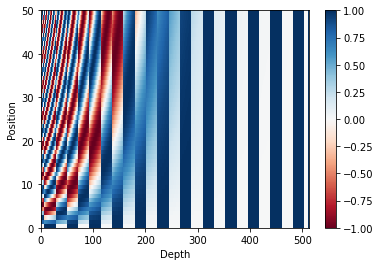

In [16]:
pos_encoding = PositionalEncodingLayer(d_model=512)(torch.randint(100, size=(64, 50))).numpy()
print(pos_encoding.shape)
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

***Encoder Block Layer***

In [17]:
class EncoderBlockLayer(nn.Module):
    
    def __init__(self, d_model, n_heads, hidden_size, dropout):
        super(EncoderBlockLayer, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.multi_head_attention_layer = MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads)
        self.multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.position_wise_feed_forward_layer = PositionWiseFeedForwardLayer(d_model=d_model, hidden_size=hidden_size)
        self.position_wise_feed_forward_layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, src_inputs, src_mask):
        """
        :param Tensor[batch_size, src_len, d_model] src_inputs
        :param Tensor[batch_size,  src_len] src_mask
        :return Tensor[batch_size, src_len, d_model] outputs
        """
        context, _ = self.multi_head_attention_layer(query=src_inputs, key=src_inputs, value=src_inputs, mask=src_mask)
        context = self.multi_head_attention_layer_norm(self.dropout(context) + src_inputs)
        
        outputs = self.position_wise_feed_forward_layer(context)
        outputs = self.position_wise_feed_forward_layer_norm(self.dropout(outputs) + context)
        
        return outputs

***Decoder Block Layer***

In [18]:
class DecoderBlockLayer(nn.Module):
    
    def __init__(self, d_model, n_heads, hidden_size, dropout):
        super(DecoderBlockLayer, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.mask_multi_head_attention_layer = MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads)
        self.mask_multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.multi_head_attention_layer = MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads)
        self.multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.position_wise_feed_forward_layer = PositionWiseFeedForwardLayer(d_model=d_model, hidden_size=hidden_size)
        self.position_wise_feed_forward_layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, dest_inputs, src_encoded, dest_mask, src_mask):
        """
        :param Tensor[batch_size, dest_len, d_model] dest_inputs
        :param Tensor[batch_size, src_len, d_model] src_encoded
        :param Tensor[batch_size,  dest_len] dest_mask
        :param Tensor[batch_size,  src_len] src_mask
        :return Tensor[batch_size, dest_len, d_model] outputs
        :return Tensor[batch_size, n_heads, dest_len, src_len] attention_weights
        """
        masked_context, _ = self.mask_multi_head_attention_layer(query=dest_inputs, key=dest_inputs, value=dest_inputs, mask=dest_mask)
        masked_context = self.mask_multi_head_attention_layer_norm(self.dropout(masked_context) + dest_inputs)
        
        context, attention_weights = self.multi_head_attention_layer(query=masked_context, key=src_encoded, value=src_encoded, mask=src_mask)
        context = self.multi_head_attention_layer_norm(self.dropout(context) + masked_context)
        
        outputs = self.position_wise_feed_forward_layer(context)
        outputs = self.position_wise_feed_forward_layer_norm(self.dropout(outputs) + context)
        
        return outputs, attention_weights

***Encoder Layer***

In [19]:
class EncoderLayer(nn.Module):
    
    def __init__(self, vocab_size, max_len, d_model, n_heads, hidden_size, dropout, n_layers):
        super(EncoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.n_layers = n_layers
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncodingLayer(d_model=d_model, max_len=max_len)
        self.encoder_block_layers = nn.ModuleList([EncoderBlockLayer(d_model=d_model, n_heads=n_heads, hidden_size=hidden_size,
                                                                     dropout=dropout) for _ in range(n_layers)])
    
    def forward(self, src_sequences, src_mask):
        """
        :param Tensor[batch_size, src_len] src_sequences
        :param Tensor[batch_size, src_len] src_mask
        :return Tensor[batch_size, src_len, d_model] outputs
        """
        token_embedded = self.token_embedding(src_sequences) # [batch_size, src_len, d_model]
        position_encoded = self.position_encoding(src_sequences) # [batch_size, src_len, d_model]
        outputs = self.dropout(token_embedded) + position_encoded # [batch_size, src_len, d_model]
        for layer in self.encoder_block_layers:
            outputs = layer(src_inputs=outputs, src_mask=src_mask) # [batch_size, src_len, d_model]
        return outputs

***Decoder Layer***

In [20]:
class DecoderLayer(nn.Module):
    
    def __init__(self, vocab_size, max_len, d_model, n_heads, hidden_size, dropout, n_layers):
        super(DecoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.n_layers = n_layers
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncodingLayer(d_model=d_model, max_len=max_len)
        self.decoder_block_layers = nn.ModuleList([DecoderBlockLayer(d_model=d_model, n_heads=n_heads, hidden_size=hidden_size, dropout=dropout) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, vocab_size)
    
    def forward(self, dest_sequences, src_encoded, dest_mask, src_mask):
        """
        :param Tensor[batch_size, dest_len] dest_sequences
        :param Tensor[batch_size, src_len, d_model] src_encoded
        :param Tensor[batch_size, dest_len, d_model] dest_mask
        :param Tensor[batch_size, src_len, d_model] src_mask
        :return Tensor[batch_size, dest_len, vocab_size] logits
        :return Tensor[batch_size, n_heads, dest_len, src_len] attention_weights
        """
        token_embedded = self.token_embedding(dest_sequences) # [batch_size, dest_len, d_model]
        position_encoded = self.position_encoding(dest_sequences) # [batch_size, dest_len, d_model]
        outputs = self.dropout(token_embedded) + position_encoded # [batch_size, dest_len, d_model]
        for layer in self.decoder_block_layers:
            outputs, attention_weights = layer(dest_inputs=outputs, src_encoded=src_encoded, dest_mask=dest_mask, src_mask=src_mask)
        logits = self.fc(outputs)
        return logits, attention_weights

***Transformer Model***

In [21]:
class Transformer(nn.Module):
    
    def __init__(self, encoder, decoder, src_pad_index, dest_pad_index):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_index = src_pad_index
        self.dest_pad_index = dest_pad_index

    def make_src_mask(self, src_sequences):
        """Mask <pad> tokens.
        :param Tensor[batch_size, src_len] src_sequences
        :return Tensor[batch size, 1, 1, src len] src_mask
        """        
        src_mask = (src_sequences != self.src_pad_index).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_dest_mask(self, dest_sequences):
        """Mask <pad> tokens and futur tokens as well.
        :param Tensor[batch_size, dest_len] dest_sequences
        :return tensor[batch_size, 1, dest_len, dest_len] dest_mask
        """
        mask = (dest_sequences != self.dest_pad_index).unsqueeze(1).unsqueeze(2) # [batch size, 1, 1, trg len]
        sub_mask = torch.tril(torch.ones((dest_sequences.size(1), dest_sequences.size(1))).to(dest_sequences.device)).bool() # [trg len, trg len]        
        return mask & sub_mask
    
    def forward(self, src_sequences, dest_sequences):
        """
        :param Tensor[batch_size, src_len] src_sequences
        :param Tensor[batch_size, dest_len] dest_sequences
        :return Tensor[batch_size, dest_len, vocab_size] logits
        :return Tensor[batch_size, n_heads, dest_len, src_len] attention_weights
        """
        src_mask, dest_mask = self.make_src_mask(src_sequences), self.make_dest_mask(dest_sequences)
        src_encoded = self.encoder(src_sequences=src_sequences, src_mask=src_mask)
        logits, attention_weights = self.decoder(dest_sequences=dest_sequences, src_encoded=src_encoded, dest_mask=dest_mask, src_mask=src_mask)
        return logits, attention_weights

***Training routines***

In [22]:
class AverageMeter:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [23]:
def accuracy(outputs, target_sequences, k=5):
    """ Calculate Top-k accuracy
    :param Tensor[batch_size, dest_seq_len, vocab_size] outputs
    :param Tensor[batch_size, dest_seq_len] target_sequences
    :return float Top-k accuracy
    """
    # print([*map(lambda token: EN.vocab.itos[token], outputs.argmax(dim=-1)[0].tolist())])
    # print([*map(lambda token: EN.vocab.itos[token], target_sequences[0].tolist())])
    # print("="*100)
    batch_size = target_sequences.size(0)
    _, indices = outputs.topk(k, dim=2, largest=True, sorted=True) # [batch_size, dest_seq_len, 5]
    correct = indices.eq(target_sequences.unsqueeze(-1).expand_as(indices))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / indices.numel())

In [24]:
class Trainer:
    
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
    
    def train_step(self, loader, epoch, grad_clip):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, batch in progress_bar:
            src, trg = batch.src, batch.trg
            self.optimizer.zero_grad()
            logits, _ = self.model(src, trg[:, :-1]) # [batch_size, dest_len, vocab_size]
            loss = self.criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), trg[:, 1:].contiguous().view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
            self.optimizer.step()
            loss_tracker.update(loss.item())
            acc_tracker.update(accuracy(logits, trg[:, 1:]))
            loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_:.3f} -     ppl: {ppl_:.3f} -     acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def validate(self, loader, epoch):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
            for i, batch in progress_bar:
                src, trg = batch.src, batch.trg
                logits, _ = self.model(src, trg[:, :-1]) # [batch_size, dest_len, vocab_size]
                loss = self.criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), trg[:, 1:].contiguous().view(-1))
                loss_tracker.update(loss.item())
                acc_tracker.update(accuracy(logits, trg[:, 1:]))
                loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_:.3f} - val_ppl: {ppl_:.3f} - val_acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def train(self, train_loader, valid_loader, n_epochs, grad_clip):
        history, best_loss = {'acc': [], 'loss': [], 'ppl': [], 'val_ppl': [], 'val_acc': [], 'val_loss': []}, np.inf
        
        
        for epoch in range(n_epochs):
            start_time = time.time()
            loss, ppl, acc = self.train_step(train_loader, epoch, grad_clip)
            val_loss, val_ppl, val_acc = self.validate(valid_loader, epoch)
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save({'epoch': epoch + 1,
                    'state_dict': self.model.state_dict(),
                    'optimizer' : self.optimizer.state_dict(), 'chk_train_loss' : loss,   'chk_valid_loss' : val_loss
                     }, './pre-training-LTR-transformer.pth')
            
            end_time = time.time()  
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)               
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')    
                
            history['acc'].append(acc); history['val_acc'].append(val_acc)
            history['ppl'].append(ppl); history['val_ppl'].append(val_ppl)
            history['loss'].append(loss); history['val_loss'].append(val_loss)
        return history

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

***Train the model***

In [26]:
D_MODEL = 256
N_LAYERS = 4
N_HEADS = 8
HIDDEN_SIZE = 512
MAX_LEN = 400
DROPOUT = 0.15
BATCH_SIZE = 128
LR = 1e-3
N_EPOCHS = 10
GRAD_CLIP = 1

In [30]:
class MultipleGPUs(nn.DataParallel):
    def __getattr__(self, name):
        if name == "module":
            return super().__getattr__("module")
        else:
            return getattr(self.module, name)

In [27]:
transformer = Transformer(
    encoder=EncoderLayer(
        vocab_size=len(SRC.vocab),
        max_len=MAX_LEN,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        hidden_size=HIDDEN_SIZE,
        dropout=DROPOUT,
        n_layers=N_LAYERS
    ),
    decoder=DecoderLayer(
        vocab_size=len(TRG.vocab),
        max_len=MAX_LEN,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        hidden_size=HIDDEN_SIZE,
        dropout=DROPOUT,
        n_layers=N_LAYERS
    ),
    src_pad_index=SRC.vocab.stoi[SRC.pad_token],
    dest_pad_index=TRG.vocab.stoi[TRG.pad_token]
).to(DEVICE)

#transformer = MultipleGPUs(transformer).to(DEVICE)

optimizer = optim.Adam(params=transformer.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi[TRG.pad_token])
trainer = Trainer(model=transformer, optimizer=optimizer, criterion=criterion)

In [28]:
train_iterator, valid_iterator =  BucketIterator.splits((train_data, valid_data), sort_key=lambda x: len(x.src),
     batch_size = BATCH_SIZE, device = DEVICE)

In [29]:
history = trainer.train(train_loader=train_iterator, valid_loader=valid_iterator, n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

Epoch: 01 -     loss: 2.312 -     ppl: 10.099 -     acc: 4.371%: 100%|██████████| 443/443 [01:04<00:00,  6.87it/s]
Epoch: 01 - val_loss: 0.957 - val_ppl: 2.604 - val_acc: 15.171%: 100%|██████████| 35/35 [00:00<00:00, 62.17it/s]
  0%|          | 0/443 [00:00<?, ?it/s]

Epoch: 01 | Time: 1m 5s


Epoch: 02 -     loss: 0.972 -     ppl: 2.644 -     acc: 5.465%: 100%|██████████| 443/443 [01:05<00:00,  6.79it/s]
Epoch: 02 - val_loss: 0.676 - val_ppl: 1.967 - val_acc: 15.665%: 100%|██████████| 35/35 [00:00<00:00, 61.53it/s]
  0%|          | 0/443 [00:00<?, ?it/s]

Epoch: 02 | Time: 1m 5s


Epoch: 03 -     loss: 0.683 -     ppl: 1.980 -     acc: 5.585%: 100%|██████████| 443/443 [01:05<00:00,  6.79it/s]
Epoch: 03 - val_loss: 0.557 - val_ppl: 1.746 - val_acc: 15.836%: 100%|██████████| 35/35 [00:00<00:00, 62.24it/s]
Epoch: 04 -     loss: 0.566 -     ppl: 1.762 -     acc: 6.438%:   0%|          | 1/443 [00:00<01:16,  5.80it/s]

Epoch: 03 | Time: 1m 5s


Epoch: 04 -     loss: 0.555 -     ppl: 1.742 -     acc: 5.661%: 100%|██████████| 443/443 [01:05<00:00,  6.77it/s]
Epoch: 04 - val_loss: 0.509 - val_ppl: 1.663 - val_acc: 15.902%: 100%|██████████| 35/35 [00:00<00:00, 62.03it/s]
Epoch: 05 -     loss: 0.407 -     ppl: 1.503 -     acc: 7.576%:   0%|          | 1/443 [00:00<01:16,  5.76it/s]

Epoch: 04 | Time: 1m 6s


Epoch: 05 -     loss: 0.484 -     ppl: 1.623 -     acc: 5.719%: 100%|██████████| 443/443 [01:05<00:00,  6.79it/s]
Epoch: 05 - val_loss: 0.488 - val_ppl: 1.629 - val_acc: 15.929%: 100%|██████████| 35/35 [00:00<00:00, 61.92it/s]
  0%|          | 0/443 [00:00<?, ?it/s]

Epoch: 05 | Time: 1m 5s


Epoch: 06 -     loss: 0.445 -     ppl: 1.560 -     acc: 5.739%: 100%|██████████| 443/443 [01:05<00:00,  6.79it/s]
Epoch: 06 - val_loss: 0.471 - val_ppl: 1.602 - val_acc: 15.940%: 100%|██████████| 35/35 [00:00<00:00, 62.30it/s]
Epoch: 07 -     loss: 0.396 -     ppl: 1.486 -     acc: 6.253%:   0%|          | 1/443 [00:00<01:20,  5.49it/s]

Epoch: 06 | Time: 1m 5s


Epoch: 07 -     loss: 0.416 -     ppl: 1.517 -     acc: 5.733%: 100%|██████████| 443/443 [01:05<00:00,  6.75it/s]
Epoch: 07 - val_loss: 0.468 - val_ppl: 1.596 - val_acc: 15.958%: 100%|██████████| 35/35 [00:00<00:00, 59.83it/s]
  0%|          | 0/443 [00:00<?, ?it/s]

Epoch: 07 | Time: 1m 6s


Epoch: 08 -     loss: 0.393 -     ppl: 1.481 -     acc: 5.749%: 100%|██████████| 443/443 [01:05<00:00,  6.73it/s]
Epoch: 08 - val_loss: 0.462 - val_ppl: 1.588 - val_acc: 15.959%: 100%|██████████| 35/35 [00:00<00:00, 62.20it/s]
  0%|          | 0/443 [00:00<?, ?it/s]

Epoch: 08 | Time: 1m 6s


Epoch: 09 -     loss: 0.372 -     ppl: 1.451 -     acc: 5.829%: 100%|██████████| 443/443 [01:05<00:00,  6.79it/s]
Epoch: 09 - val_loss: 0.453 - val_ppl: 1.573 - val_acc: 15.977%: 100%|██████████| 35/35 [00:00<00:00, 61.64it/s]
Epoch: 10 -     loss: 0.344 -     ppl: 1.410 -     acc: 6.744%:   0%|          | 1/443 [00:00<01:17,  5.69it/s]

Epoch: 09 | Time: 1m 5s


Epoch: 10 -     loss: 0.357 -     ppl: 1.429 -     acc: 5.813%: 100%|██████████| 443/443 [01:05<00:00,  6.81it/s]
Epoch: 10 - val_loss: 0.447 - val_ppl: 1.564 - val_acc: 15.989%: 100%|██████████| 35/35 [00:00<00:00, 64.46it/s] 


Epoch: 10 | Time: 1m 5s


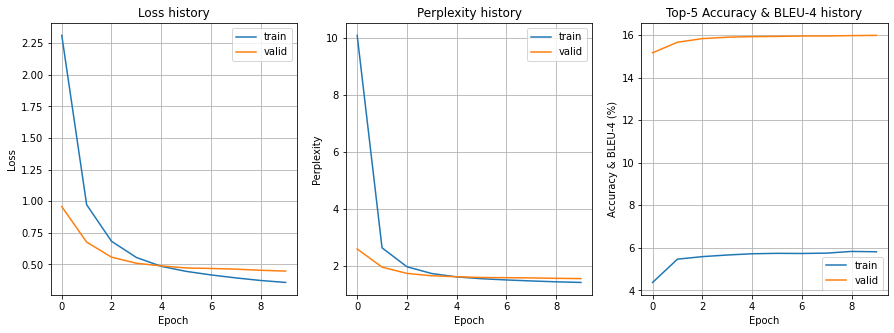

In [30]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['acc'], label='train')
axes[2].plot(history['val_acc'], label='valid')
axes[2].set_title('Top-5 Accuracy & BLEU-4 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy & BLEU-4 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

In [31]:
D_MODEL = 256
N_LAYERS = 4
N_HEADS = 8
HIDDEN_SIZE = 512
MAX_LEN = 400
DROPOUT = 0.15
BATCH_SIZE = 128
LR = 1e-1
N_EPOCHS = 2
GRAD_CLIP = 1.0

In [32]:
train_data, valid_data = TabularDataset.splits(path='Data/',train='fce-train.csv',
    validation='fce-devlop.csv' , format='csv',
    fields=[('src', SRC), ('trg', TRG)], skip_header=True)

In [33]:
checkpoint = torch.load('./pre-training-LTR-transformer.pth')
optimizer.load_state_dict(checkpoint['optimizer'])          
epoch = checkpoint['epoch'] 
train_loss = checkpoint['chk_train_loss']
valid_loss = checkpoint['chk_valid_loss']
transformer.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [34]:
train_iterator, valid_iterator, _ =  BucketIterator.splits((train_data, valid_data, test_data), sort_key=lambda x: len(x.src),
     batch_size = BATCH_SIZE, device = DEVICE)

In [35]:
history = trainer.train(train_loader=train_iterator, valid_loader=valid_iterator, n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

Epoch: 01 -     loss: 0.293 -     ppl: 1.340 -     acc: 5.740%: 100%|██████████| 222/222 [00:32<00:00,  6.85it/s]
Epoch: 01 - val_loss: 0.394 - val_ppl: 1.482 - val_acc: 15.107%: 100%|██████████| 18/18 [00:00<00:00, 59.83it/s]
Epoch: 02 -     loss: 0.255 -     ppl: 1.290 -     acc: 7.178%:   0%|          | 1/222 [00:00<00:33,  6.64it/s]

Epoch: 01 | Time: 0m 32s


Epoch: 02 -     loss: 0.259 -     ppl: 1.296 -     acc: 5.805%: 100%|██████████| 222/222 [00:32<00:00,  6.80it/s]
Epoch: 02 - val_loss: 0.401 - val_ppl: 1.493 - val_acc: 15.113%: 100%|██████████| 18/18 [00:00<00:00, 60.40it/s]

Epoch: 02 | Time: 0m 32s


In [36]:
checkpoint = torch.load('./pre-training-LTR-transformer.pth')
optimizer.load_state_dict(checkpoint['optimizer'])          
epoch = checkpoint['epoch'] 
train_loss = checkpoint['chk_train_loss']
valid_loss = checkpoint['chk_valid_loss']
transformer.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

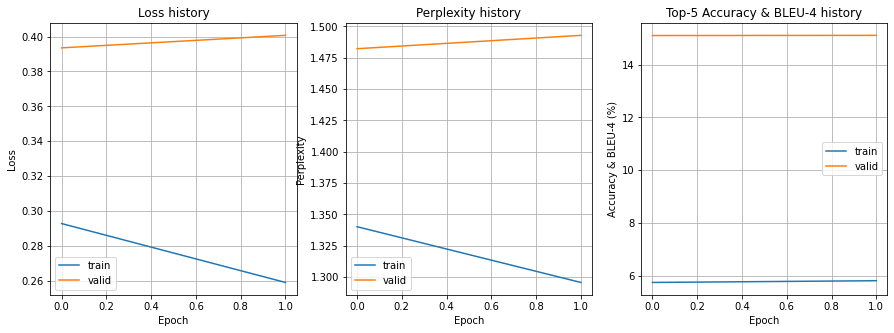

In [37]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['acc'], label='train')
axes[2].plot(history['val_acc'], label='valid')
axes[2].set_title('Top-5 Accuracy & BLEU-4 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy & BLEU-4 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

## Evaluation - Beam search & BLEU score

In [38]:
from beam_utils import Node, find_best_path, find_path

In [39]:
def evaluate(model, data, beam_size, src_field, dest_field, max_len, device):
    src_sentences = [*map(lambda example: example.src, data.examples)]
    dest_sentences = [*map(lambda example: example.trg, data.examples)]
    data = [*zip([*map(lambda word_list: src_field.process([word_list]), src_sentences)],
                 [*map(lambda word_list: dest_field.process([word_list]), dest_sentences)])]
    references, hypotheses, sources = [], [], []
    model.eval()
    with torch.no_grad():
        for i, (src_sequence, dest_sequence) in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence, dest_sequence = src_sequence.to(device), dest_sequence.to(device)
            src_mask = model.make_src_mask(src_sequence)
            src_encoded = model.encoder(src_sequences=src_sequence, src_mask=src_mask)
            # Decoding
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=None)]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    # Get tokens that're already translated
                    already_translated = torch.LongTensor([*map(lambda node: node.token, find_path(tree))][::-1]).unsqueeze(0).to(device)
                    dest_mask = model.make_dest_mask(already_translated)
                    logit, _ = model.decoder(dest_sequences=already_translated, src_encoded=src_encoded,
                                              dest_mask=dest_mask, src_mask=src_mask) # [1, dest_seq_len, vocab_size]                    
                    logp = F.log_softmax(logit[:, -1, :], dim=1).squeeze(dim=0) # [vocab_size] Get scores                    
                    topk_logps, topk_tokens = torch.topk(logp, beam_size) # Get top k tokens & logps                    
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=None,
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True) # Sort next_nodes to get the best
                tree.append(next_nodes[:beam_size]) # Update the tree
            best_path = find_best_path(tree) # Find the best path of the tree

            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [dest_field.init_token, dest_field.eos_token], pred_translated[::-1])]

            hypotheses.append(pred_translated) # Update hypotheses

            # Update references
            references.append([[dest_field.vocab.itos[indice] for indice in dest_sequence[0] if indice not in (
                dest_field.vocab.stoi[dest_field.init_token],
                dest_field.vocab.stoi[dest_field.eos_token],
                dest_field.vocab.stoi[dest_field.pad_token]
            )]])

            # Update sources
            sources.append([src_field.vocab.itos[indice]  for indice in src_sequence[0] if indice not in (
                src_field.vocab.stoi[src_field.init_token],
                src_field.vocab.stoi[src_field.eos_token],
                src_field.vocab.stoi[src_field.pad_token]
            )])
    
        assert len(hypotheses) == len(references) == len(sources)
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25]) # Calculate BLEU-4 score
    return hypotheses, references, sources, bleu4

In [40]:
bleu_scores = []
for beam_size in [1]:
    for name, data in [('test', test_data)]:
        _, _, _, bleu4 = evaluate(model=transformer, data=data, beam_size=beam_size, src_field=SRC, dest_field=TRG, max_len=MAX_LEN, device=DEVICE)
        bleu_scores.append((beam_size, name, bleu4))
        
for score in bleu_scores:
    print(f'BLEU-4: {score[2]*100:.3f}% with beam_size={score[0]} on {score[1]} data')

100%|██████████| 2695/2695 [05:40<00:00,  7.91it/s]


BLEU-4: 79.517% with beam_size=1 on test data


## Inference

In [41]:
def translate(sentences, model, beam_size, src_field, dest_field, max_len, device):
    if isinstance(sentences, list):
        sentences = [*map(src_field.preprocess, sentences)]
        targets = None
    if isinstance(sentences, Dataset):
        targets = [*map(lambda example: ' '.join(example.trg), sentences.examples)]
        sentences = [*map(lambda example: example.src, sentences.examples)]
    data = [*map(lambda word_list: src_field.process([word_list]), sentences)]
    translated_sentences, attention_weights, pred_logps = [], [], []
    model.eval()
    with torch.no_grad():
        for i, src_sequence in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence = src_sequence.to(device)
            src_mask = model.make_src_mask(src_sequence)
            src_encoded = model.encoder(src_sequences=src_sequence, src_mask=src_mask)
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=())]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    # Get tokens that're already translated
                    already_translated = torch.LongTensor([*map(lambda node: node.token, find_path(tree))][::-1]).unsqueeze(0).to(device)
                    dest_mask = model.make_dest_mask(already_translated)
                    logit, attn_weights = model.decoder(dest_sequences=already_translated, src_encoded=src_encoded,
                                              dest_mask=dest_mask, src_mask=src_mask) # [1, dest_seq_len, vocab_size]                      
                    logp = F.log_softmax(logit[:, -1, :], dim=1).squeeze(dim=0) # [vocab_size] Get scores                    
                    topk_logps, topk_tokens = torch.topk(logp, beam_size) # Get top k tokens & logps                    
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=(attn_weights,),
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True)
                tree.append(next_nodes[:beam_size])
            best_path = find_best_path(tree)[::-1]
            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [
                dest_field.init_token, dest_field.eos_token
            ], pred_translated)]
            translated_sentences.append(' '.join(pred_translated))
            # Get probabilities
            pred_logps.append(sum([*map(lambda node: node.logps, best_path)]))
            # Get attention weights
            attention_weights.append(best_path[-1].states[0].cpu().numpy())
        sentences = [*map(lambda sentence: ' '.join(sentence), sentences)]
    return sentences, translated_sentences, targets, attention_weights, pred_logps

In [42]:
sentences, translated_sentences, dest_sentences, attention_weights, pred_logps = translate(sentences=test_data, model=transformer, beam_size=1, src_field=SRC,
                                                                                           dest_field=TRG, max_len=MAX_LEN, device=DEVICE)

100%|██████████| 2695/2695 [05:35<00:00,  8.03it/s]


In [43]:
translated_sentences[0]

'▁de ar ▁m r s ▁sm ith ▁ ,'

In [44]:
trg_file = open("../m2Scripts/corec_sentes.txt", "w", encoding="utf-8")
for line in translated_sentences:
    line = line.split()
    line = "".join(line)
    line = line.replace('▁', ' ')
    trg_file.write(line + "\n")
trg_file.close()